In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load Dataset
train_data = datasets.MNIST('', train = True, download = True,
                           transform = transforms.ToTensor())
test_data = datasets.MNIST('', train = False, download = True,
                           transform = transforms.Compose([transforms.ToTensor()]))

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [6]:
type(train_data[0])

tuple

In [7]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [8]:
image, label = train_data[0]

In [9]:
label

5

In [10]:
image.shape

torch.Size([1, 28, 28])

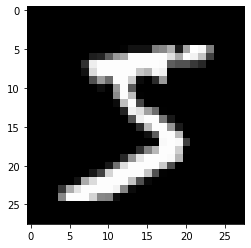

In [11]:
plt.imshow(image.reshape((28, 28)), cmap = 'gray')

In [12]:
torch.manual_seed(101) # Sets the seed for generating random numbers

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [13]:
len(train_data)


60000

In [14]:
# 1st batch
for images, labels in train_loader:
    break

In [15]:
images.shape

torch.Size([100, 1, 28, 28])

In [16]:
labels.shape

torch.Size([100])

Labels:  [0 5 7 8 6 7 9 7 1 3]


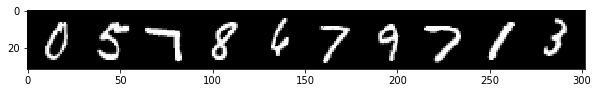

In [17]:
from torchvision.utils import make_grid
print('Labels: ', labels[:10].numpy())

img = make_grid(images[:10], nrow=10) 
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

In [18]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]): # 784 = 28*28
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1) # multi class classification

In [19]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
crit = nn.CrossEntropyLoss()
learning_rate = 0.001
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
import time
start_time = time.time()

# Training
epochs = 10

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b += 1
        
        # 10 neurons === 10 classes
        y_pred = model(X_train.view(100, -1))
        loss = crit(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if b % 200 == 0:
            accuracy = trn_corr.item() * 100 / (100 * b)
            print(f'Epoch {i} - batch {b} - loss: {loss.item()} - accuracy: {accuracy}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            y_val = model(X_test.view(500, -1)) # 500 = batch_size test_loader
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = crit(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        

total_time = time.time() - start_time
print(f'Train time: {total_time} seconds')

Epoch 0 - batch 200 - loss: 0.2758257985115051 - accuracy: 83.09
Epoch 0 - batch 400 - loss: 0.21671520173549652 - accuracy: 87.3725
Epoch 0 - batch 600 - loss: 0.21335361897945404 - accuracy: 89.38833333333334
Epoch 1 - batch 200 - loss: 0.1399226039648056 - accuracy: 94.715
Epoch 1 - batch 400 - loss: 0.1224755272269249 - accuracy: 95.2025
Epoch 1 - batch 600 - loss: 0.11743089556694031 - accuracy: 95.425
Epoch 2 - batch 200 - loss: 0.11977485567331314 - accuracy: 96.56
Epoch 2 - batch 400 - loss: 0.09125816076993942 - accuracy: 96.6725
Epoch 2 - batch 600 - loss: 0.09464908391237259 - accuracy: 96.75666666666666
Epoch 3 - batch 200 - loss: 0.04418263956904411 - accuracy: 97.58
Epoch 3 - batch 400 - loss: 0.08314775675535202 - accuracy: 97.575
Epoch 3 - batch 600 - loss: 0.04355408251285553 - accuracy: 97.575
Epoch 4 - batch 200 - loss: 0.1540089249610901 - accuracy: 97.895
Epoch 4 - batch 400 - loss: 0.11909110844135284 - accuracy: 97.9475
Epoch 4 - batch 600 - loss: 0.1439854502677

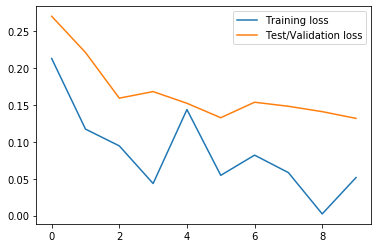

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test/Validation loss')
plt.legend()

In [23]:
train_accuracy = [t / 600 for t in train_correct]
test_accuracy = [t / 100 for t in test_correct]


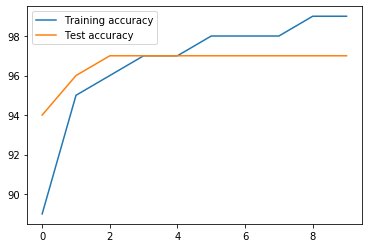

In [24]:
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(test_accuracy, label='Test accuracy')
plt.legend()